In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# =======================
# 1. IMPORTS
# =======================

import os
import zipfile
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# =======================
# 2. SET DATASET PATHS
# =======================

CONTENT_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content"
STYLE_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/style"
OUTPUT_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/outputs"
CHECKPOINT_DIR = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/checkpoints"

assert os.path.exists(CONTENT_DIR), f"Content dir not found: {CONTENT_DIR}"
assert os.path.exists(STYLE_DIR), f"Style dir not found: {STYLE_DIR}"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
checkpoint_path = os.path.join(CHECKPOINT_DIR, "adain_checkpoint.pth")

In [4]:
# =======================
# 3. IMAGE DATASET CLASS
# =======================

class StyleContentDataset(Dataset):
    def __init__(self, content_dir, style_dir, image_size=256):
        self.content_paths = sorted([
            os.path.join(content_dir, f) for f in os.listdir(content_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        self.style_paths = sorted([
            os.path.join(style_dir, f) for f in os.listdir(style_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return min(len(self.content_paths), len(self.style_paths))

    def __getitem__(self, idx):
        try:
            content = Image.open(self.content_paths[idx]).convert("RGB")
        except UnidentifiedImageError:
            print(f"[Warning] Skipping unreadable content image: {self.content_paths[idx]}")
            return self.__getitem__((idx + 1) % len(self))

        try:
            style = Image.open(self.style_paths[idx % len(self.style_paths)]).convert("RGB")
        except UnidentifiedImageError:
            print(f"[Warning] Skipping unreadable style image: {self.style_paths[idx % len(self.style_paths)]}")
            return self.__getitem__((idx + 1) % len(self))

        return self.transform(content), self.transform(style)

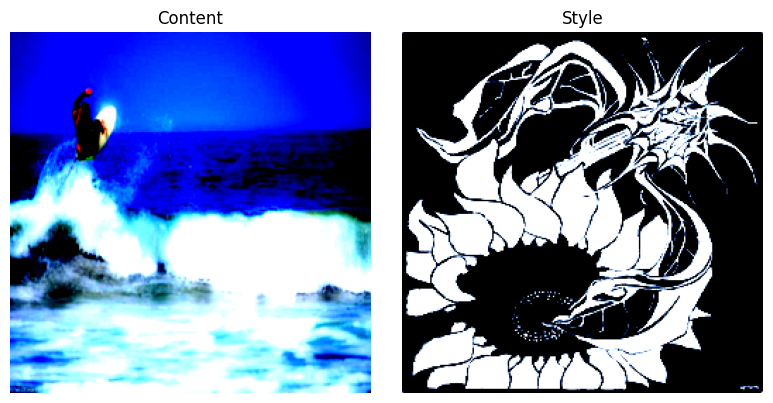

In [ ]:
dataset = StyleContentDataset(CONTENT_DIR, STYLE_DIR, image_size=256)

# Display one content-style pair
def show_sample(idx=0):
    content, style = dataset[idx]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(content.permute(1, 2, 0).numpy())
    axs[0].set_title("Content")
    axs[0].axis("off")

    axs[1].imshow(style.permute(1, 2, 0).numpy())
    axs[1].set_title("Style")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

show_sample(0)

In [5]:
# =======================
# 4. UTILS
# =======================

def mean_std(x):
    B, C, H, W = x.shape
    mean = x.view(B, C, -1).mean(2).view(B, C, 1, 1)
    std = x.view(B, C, -1).std(2).view(B, C, 1, 1) + 1e-5
    return mean, std

def adain(content_feat, style_feat):
    c_mean, c_std = mean_std(content_feat)
    s_mean, s_std = mean_std(style_feat)
    return s_std * (content_feat - c_mean) / c_std + s_mean

def adjust_learning_rate(optimizer, iteration_count, base_lr=1e-4, lr_decay=5e-5):
    lr = base_lr / (1.0 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

vgg_denorm = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def deprocess(tensor):
    tensor = tensor.cpu().clone().detach().squeeze(0)
    tensor = vgg_denorm(tensor).clamp(0, 1)
    return transforms.ToPILImage()(tensor)

In [6]:
# =======================
# 5. VGG ENCODER & LOSS
# =======================

class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.enc = nn.Sequential(*list(vgg.children())[:21])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.enc(x)

class VGG_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.blocks = nn.ModuleList([
            nn.Sequential(*list(vgg.children())[:4]),   # relu1_1
            nn.Sequential(*list(vgg.children())[:11]),  # relu2_1
            nn.Sequential(*list(vgg.children())[:18]),  # relu3_1
            nn.Sequential(*list(vgg.children())[:21])   # relu4_1
        ])
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        features = []
        # Apply each block to the original input image x
        features.append(self.blocks[0](x)) # relu1_1 features
        features.append(self.blocks[1](x)) # relu2_1 features
        features.append(self.blocks[2](x)) # relu3_1 features
        features.append(self.blocks[3](x)) # relu4_1 features
        return features

def style_loss(gen_feats, style_feats):
    loss = 0
    for g, s in zip(gen_feats, style_feats):
        gm, gs = mean_std(g)
        sm, ss = mean_std(s)
        loss += F.mse_loss(gm, sm) + F.mse_loss(gs, ss)
    return loss

def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

In [7]:
# =======================
# 6. DECODER
# =======================

class Decoder(nn.Module):
     def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3)  # Final image output
        )

     def forward(self, x):
        return self.decoder(x)

In [ ]:
def train_adain_model(num_epochs=5, batch_size=8, lr=1e-4, lr_decay=5e-5,
                alpha=1.0, content_weight=1.0, style_weight=10.0, tv_weight=1e-6,
                checkpoint_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/adain_checkpoint.pth"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load networks
    encoder = VGGEncoder().to(device).eval()
    decoder = Decoder().to(device)
    loss_net = VGG_Loss().to(device).eval()

    optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    start_epoch = 0
    iteration = 0

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        iteration = checkpoint.get('iteration', 0)
        print(f"Resumed from epoch {start_epoch}, iteration {iteration}")

    # Load and prepare dataset
    dataset = StyleContentDataset(CONTENT_DIR, STYLE_DIR)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        for i, (content, style) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            content, style = content.to(device), style.to(device)

            # Adjust learning rate based on iteration count
            adjust_learning_rate(optimizer, iteration, base_lr=lr, lr_decay=lr_decay)
            iteration += 1

            # AdaIN feature alignment
            with torch.no_grad():
                content_feat = encoder(content)
                style_feat = encoder(style)
                t = adain(content_feat, style_feat)
                t = alpha * t + (1 - alpha) * content_feat

            # Decode stylized features into image
            output = decoder(t)

            # Extract output features for content/style loss
            output_feat = encoder(output)
            c_loss = F.mse_loss(output_feat, t)
            s_loss = style_loss(loss_net(output), loss_net(style))
            tv_loss = total_variation_loss(output)

            # Combine weighted losses
            loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            if i % 200 == 0:
                print(
                    f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(loader)}] "
                    f"Content: {c_loss.item():.4f} | "
                    f"Style: {s_loss.item():.4f} | "
                    f"TV: {tv_loss.item():.4f} | "
                    f"Total: {loss.item():.4f} | "
                    f"LR: {optimizer.param_groups[0]['lr']:.6f}"
                )

                # Save and display only the first stylized image in the batch
                sample = output[0].detach().cpu() # [3, H, W]
                sample = vgg_denorm(sample).clamp(0, 1)
                img_path = os.path.join(OUTPUT_DIR, f"sample_epoch{epoch+1}_batch{i}.jpg")
                vutils.save_image(sample, img_path)  # Save one image only

                # Display that image
                plt.figure(figsize=(4, 4))
                plt.imshow(sample.permute(1, 2, 0))  # CHW -> HWC
                plt.axis("off")
                plt.title(f"Epoch {epoch+1}, Batch {i}")
                plt.tight_layout()
                plt.show()

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'iteration': iteration,
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, checkpoint_path)

        # Save standalone decoder weights
        model_path = f"/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/decoder_epoch{epoch+1}.pth"
        torch.save(decoder.state_dict(), model_path)
        print(f"Epoch {epoch+1} complete. Decoder saved to: {model_path}")

In [ ]:
train_adain_model(num_epochs=5, checkpoint_path=checkpoint_path)

In [9]:
def stylize_adain_image(content_path, style_path, decoder_path,
                        alpha=1.0, image_size=256, output_path=None):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    encoder = VGGEncoder().to(device).eval()
    decoder = Decoder().to(device)
    decoder.load_state_dict(torch.load(decoder_path, map_location=device))
    decoder.eval()

    # Image transforms
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    transform_display = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])

    def load_image(path, display=False):
        img = Image.open(path).convert("RGB")
        return (transform_display if display else transform)(img).unsqueeze(0).to(device)

    content = load_image(content_path)
    style = load_image(style_path)
    content_disp = load_image(content_path, display=True).squeeze(0).cpu()
    style_disp = load_image(style_path, display=True).squeeze(0).cpu()

    # AdaIN alignment
    def adain(c_feat, s_feat, eps=1e-5):
        c_mean, c_std = c_feat.mean([2, 3], keepdim=True), c_feat.std([2, 3], keepdim=True)
        s_mean, s_std = s_feat.mean([2, 3], keepdim=True), s_feat.std([2, 3], keepdim=True)
        return (c_feat - c_mean) / (c_std + eps) * s_std + s_mean

    def vgg_denorm(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
        return tensor * std + mean

    # Stylize
    with torch.no_grad():
        c_feat = encoder(content)
        s_feat = encoder(style)
        t = adain(c_feat, s_feat)
        t = alpha * t + (1 - alpha) * c_feat
        output = decoder(t)
        output = vgg_denorm(output).clamp(0, 1).cpu().squeeze(0)

    # Save result
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        vutils.save_image(output, output_path)
        print(f"Stylized image saved to: {output_path}")

    # Side-by-side visualization
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(content_disp.permute(1, 2, 0))
    axs[0].set_title("Content")
    axs[1].imshow(style_disp.permute(1, 2, 0))
    axs[1].set_title("Style")
    axs[2].imshow(output.permute(1, 2, 0))
    axs[2].set_title("Stylized")
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Stylized image saved to: /content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/outputs/stylized_houses_visitor.jpg


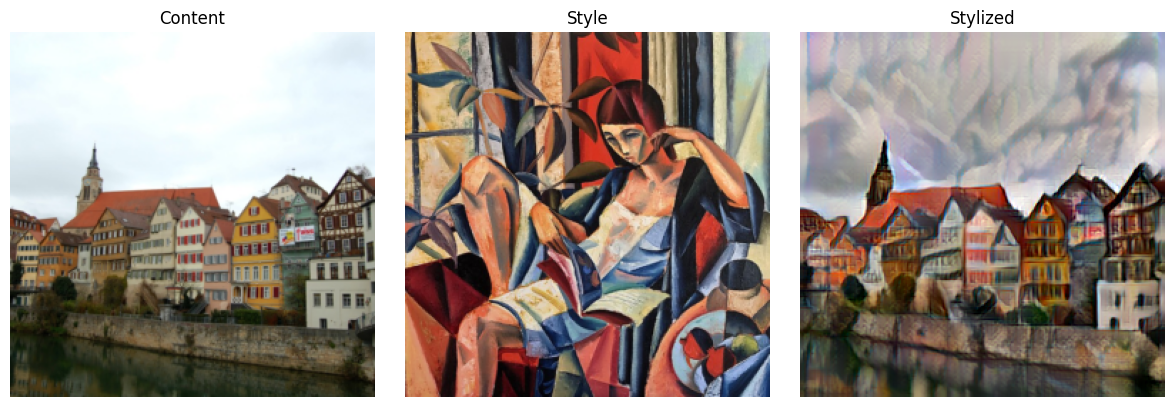

In [12]:
stylize_adain_image(
    content_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/houses_content.jpg",
    style_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/test_styles/The_Visitor_by_Hennie_Niemann.jpg",
    decoder_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/hparams_models/adain_model_hyp_c5.0_s10.0_adam.pth",
    output_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/outputs/stylized_houses_visitor.jpg",
    alpha=0.5
)